In [ ]:
!pip install htsprophet

In [ ]:
import os
import pandas as pd
import numpy as np
import datetime

import itertools

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import htsprophet

import logging
logger = logging.getLogger()
logger.handlers = []

from IPython.display import display

pd.set_option('display.float_format', lambda x: '{:.15f}'.format(x))

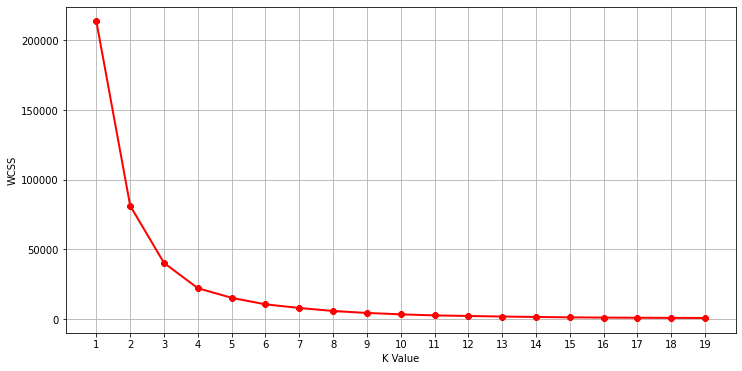

In [ ]:
df_shipment = pd.read_csv('result_shipment_only.csv')
#df2 = pd.read_csv('result_shipment_only_2.csv')
#df3 = pd.read_csv('result_shipment_only_3.csv')
#df = pd.concat([df1, df2, df3])
#df_shipment = df_shipment.assign(generic_cust_item_id=(df_shipment['UCH_LEVEL_G'].astype(str) + '_' + df_shipment['BASECODE'].astype(str)).astype('category').cat.codes)
df_shipment.columns = [c.lower() for c in df_shipment.columns]
#Converting fscl_wk_end_dt column to datetime format
df_shipment['fscl_wk_end_dt'] = pd.to_datetime(df_shipment['fscl_wk_end_dt'])
#df_shipment.set_index('fscl_wk_end_dt', inplace=True)

df_cust_po = pd.read_csv('result_cust_po.csv')
#df2 = pd.read_csv('result_shipment_only_2.csv')
#df3 = pd.read_csv('result_shipment_only_3.csv')
#df = pd.concat([df1, df2, df3])
#df_cust_po = df_cust_po.assign(generic_cust_item_id=(df_cust_po['UCH_LEVEL_G'].astype(str) + '_' + df_cust_po['BASECODE'].astype(str)).astype('category').cat.codes)
df_cust_po.columns = [c.lower() for c in df_cust_po.columns]
#Converting fscl_wk_end_dt column to datetime format
df_cust_po['fscl_wk_end_dt'] = pd.to_datetime(df_cust_po['fscl_wk_end_dt'])
#df_cust_po.set_index('fscl_wk_end_dt', inplace=True)

df_po_vs_shipment = pd.merge(df_shipment[['uch_level_g','basecode','fscl_wk_end_dt','sales_document','material','dlv_units']], df_cust_po[['uch_level_g','basecode','fscl_wk_end_dt','sales_document','material','total_units_ordered']], on=['uch_level_g','basecode','fscl_wk_end_dt','sales_document','material'], how="inner")
df_po_vs_shipment = df_po_vs_shipment.assign(generic_cust_item_id=(df_po_vs_shipment['uch_level_g'].astype(str) + '_' + df_po_vs_shipment['basecode'].astype(str)).astype('category').cat.codes)

df_po_vs_shipment.set_index(['fscl_wk_end_dt'], inplace=True)
df_po_vs_shipment.total_units_ordered = df_po_vs_shipment.total_units_ordered.astype(int)
df_po_vs_shipment = df_po_vs_shipment[['uch_level_g','basecode','generic_cust_item_id', 'dlv_units']]
df_po_vs_shipment.to_csv('df_po_vs_shipment.csv')

df_po_vs_shipment_agg=df_po_vs_shipment.reset_index().groupby(['uch_level_g','basecode','generic_cust_item_id', 'fscl_wk_end_dt'])[["dlv_units"]].agg(["sum"]).reset_index()
df_po_vs_shipment_agg.columns = ['uch_level_g','basecode','generic_cust_item_id', 'fscl_wk_end_dt','dlv_units']
df_po_vs_shipment_agg.set_index('fscl_wk_end_dt', inplace=True)
df_po_vs_shipment_agg

df_po_vs_shipment_agg_stat=df_po_vs_shipment_agg.groupby(['uch_level_g','basecode','generic_cust_item_id'])[["dlv_units"]].agg(["count","sum","mean","std"])
df_po_vs_shipment_agg_stat.columns = ['dlv_units_count','dlv_units_sum','dlv_units_avg','dlv_units_std']
df_po_vs_shipment_agg_stat['dlv_units_cv_times_cnt'] = (df_po_vs_shipment_agg_stat.dlv_units_std / df_po_vs_shipment_agg_stat.dlv_units_avg) * df_po_vs_shipment_agg_stat.dlv_units_count
df_po_vs_shipment_agg_stat.reset_index(inplace=True)
#df_po_vs_shipment_agg_stat = df_po_vs_shipment_agg_stat.assign(generic_cust_item_id=(df_po_vs_shipment_agg_stat['uch_level_g'].astype(str) + '_' + df_po_vs_shipment_agg_stat['basecode'].astype(str)).astype('category').cat.codes)
df_po_vs_shipment_agg_stat = df_po_vs_shipment_agg_stat.assign(generic_cust_id=(df_po_vs_shipment_agg_stat['uch_level_g'].astype(str)).astype('category').cat.codes)
df_po_vs_shipment_agg_stat = df_po_vs_shipment_agg_stat.assign(generic_item_id=(df_po_vs_shipment_agg_stat['basecode'].astype(str)).astype('category').cat.codes)
df_po_vs_shipment_agg_stat = df_po_vs_shipment_agg_stat.dropna()
#df_po_vs_shipment_agg_stat.head()

from sklearn.cluster import KMeans
wcss = []
for k in range(1,20):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_po_vs_shipment_agg_stat[['generic_cust_item_id','dlv_units_cv_times_cnt']].iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,20),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,20,1))
plt.ylabel("WCSS")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


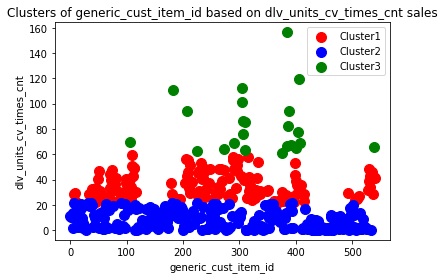

In [ ]:
#Fitting K-MEans to the dataset
kmeans=KMeans(n_clusters=3,init='k-means++',random_state=0)
y_kmeans=kmeans.fit_predict(df_po_vs_shipment_agg_stat[['dlv_units_cv_times_cnt']])
y_kmeans

new_df = df_po_vs_shipment_agg_stat[['generic_cust_item_id','dlv_units_cv_times_cnt']]
new_df['cluster_number'] = y_kmeans
new_df

plt.scatter(new_df[new_df.cluster_number ==0]['generic_cust_item_id'],new_df[new_df.cluster_number ==0]['dlv_units_cv_times_cnt'],s=100,c='red',label='Cluster1')
plt.scatter(new_df[new_df.cluster_number ==1]['generic_cust_item_id'],new_df[new_df.cluster_number ==1]['dlv_units_cv_times_cnt'],s=100,c='blue',label='Cluster2')
plt.scatter(new_df[new_df.cluster_number ==2]['generic_cust_item_id'],new_df[new_df.cluster_number ==2]['dlv_units_cv_times_cnt'],s=100,c='green',label='Cluster3')
#plt.scatter(new_df[new_df.cluster_number ==3]['generic_cust_item_id'],new_df[new_df.cluster_number ==3]['dlv_units_cv_times_cnt'],s=100,c='orange',label='Cluster4')

plt.title('Clusters of generic_cust_item_id based on dlv_units_cv_times_cnt sales')
plt.xlabel('generic_cust_item_id')
plt.ylabel('dlv_units_cv_times_cnt')
plt.legend()

plt.show()

In [ ]:
t_df = pd.merge(df_po_vs_shipment_agg.reset_index()[['fscl_wk_end_dt','uch_level_g','basecode','generic_cust_item_id','dlv_units']], df_po_vs_shipment_agg_stat[['uch_level_g','basecode','generic_cust_item_id']], on=['uch_level_g','basecode','generic_cust_item_id'], how="inner")[['fscl_wk_end_dt','uch_level_g','basecode','generic_cust_item_id','dlv_units']]
df_final_0 = t_df[(t_df['generic_cust_item_id'].isin(new_df[new_df.cluster_number == 0].generic_cust_item_id.to_list()))]
df_final_1 = t_df[(t_df['generic_cust_item_id'].isin(new_df[new_df.cluster_number == 1].generic_cust_item_id.to_list()))]
df_final_2 = t_df[(t_df['generic_cust_item_id'].isin(new_df[new_df.cluster_number == 2].generic_cust_item_id.to_list()))]
#df_final = pd.concat([df_final_0, df_final_1, df_final_2])
df_final = pd.concat([df_final_1, df_final_2])
df_final['uch_level_g_basecode'] = 'cust_' + df_final['uch_level_g'] + '_basecode_' + df_final['basecode'].astype(str)
col_dict = {}
for index, row in df_final[['uch_level_g','basecode','generic_cust_item_id']].iterrows():
    col_dict['generic_cust_item_id_' + str(row[2])] = 'cust_' + row[0] + '_basecode_' + str(row[1])
df_final.set_index('fscl_wk_end_dt',inplace=True)    
df_final.head()

,uch_level_g,basecode,generic_cust_item_id,dlv_units,uch_level_g_basecode
fscl_wk_end_dt,,,,,
2017-11-25,CA4000320,681000145500,0,38,cust_CA4000320_basecode_681000145500
2017-12-23,CA4000320,681000145500,0,34,cust_CA4000320_basecode_681000145500
2018-02-03,CA4000320,681000145500,0,40,cust_CA4000320_basecode_681000145500
2018-03-17,CA4000320,681000145500,0,35,cust_CA4000320_basecode_681000145500
2018-04-28,CA4000320,681000145500,0,43,cust_CA4000320_basecode_681000145500


In [ ]:
df_final.groupby("uch_level_g")["basecode"].apply(set).to_frame()

,basecode
uch_level_g,
CA4000320,"{681000145900, 681000147700, 681000145500, 681..."
CA4000324,"{681009006600, 681008962700, 681008959000, 681..."
CA4000326,"{681008938400, 681008987200, 681009006400, 681..."
CA4000327,"{681008938400, 681000145500, 681008959400}"
CA4000342,"{681008962600, 681008962700, 681008959500, 681..."
CA4000350,"{681008987200, 681009016000, 681000027300, 681..."
CA4000358,"{681008965000, 681009006600, 681008959500, 681..."
CA4000362,"{681008959100, 681009006400, 681000146500, 681..."
CA4000364,"{681009006400, 681009016000, 681000027300, 681..."


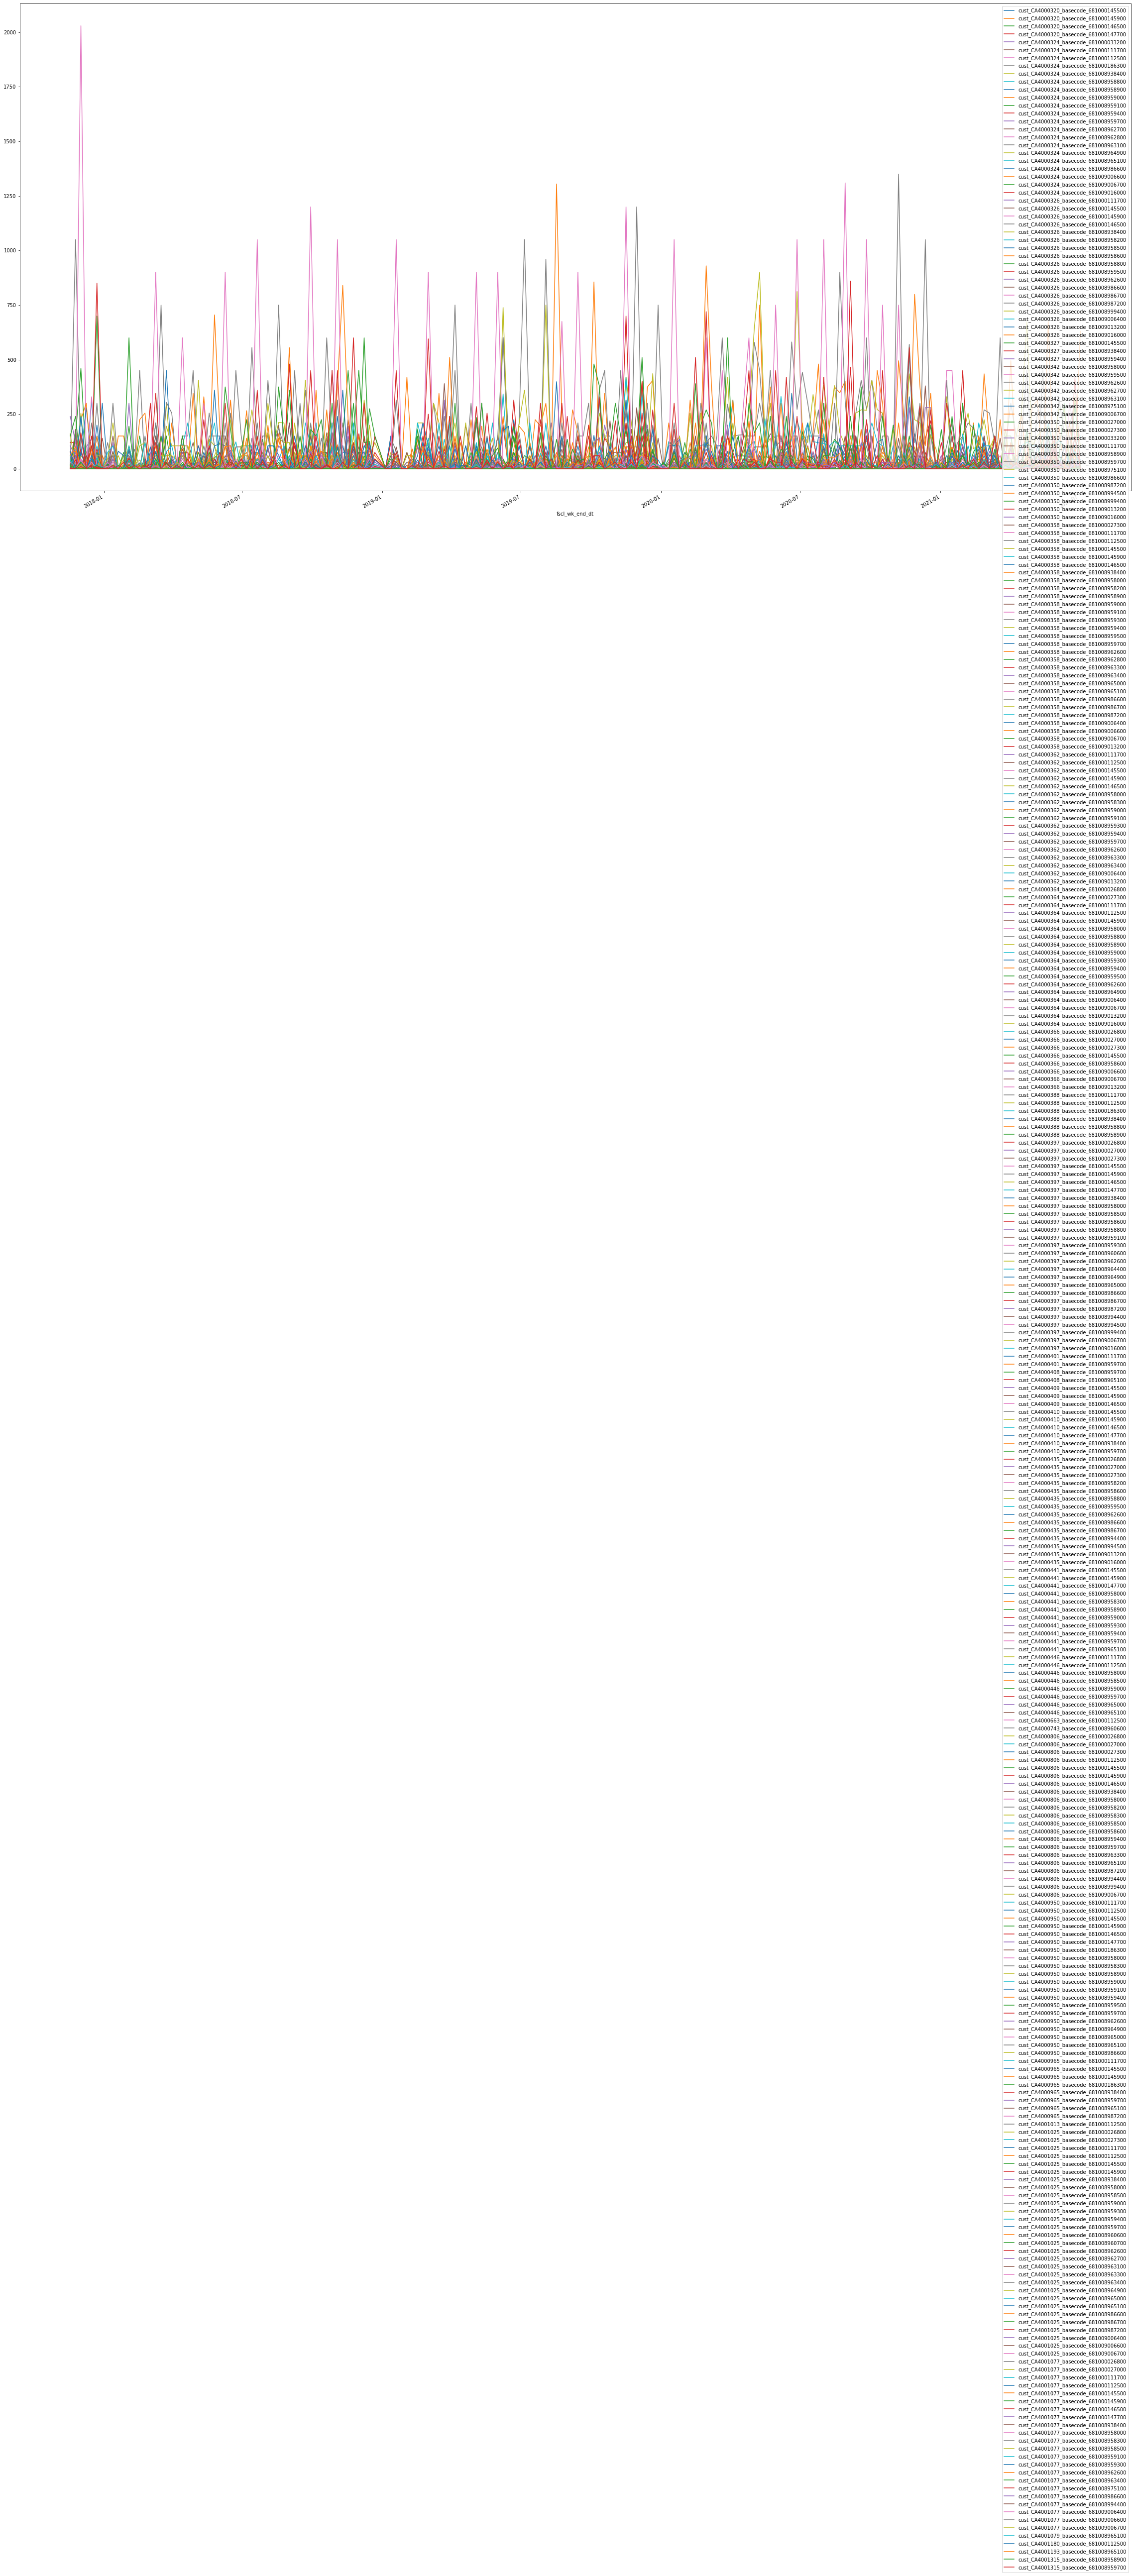

In [ ]:
df_bottom_level = df_final.pivot(columns="generic_cust_item_id", values="dlv_units")
df_bottom_level = df_bottom_level.fillna(0)
df_bottom_level.columns = ['generic_cust_item_id_' + str(c) for c in df_bottom_level.columns]
#df_bottom_level.head()

modified_col_list = []
for c in df_bottom_level.columns:
    modified_col_list.append(col_dict[c])

df_bottom_level.columns = modified_col_list
df_bottom_level.head()
#df_bottom_level.reset_index(inplace=True)
#df_bottom_level = df_bottom_level.asfreq('W-Sat')

#df_bottom_level.head()
df_bottom_level.plot(figsize = (40,20))

In [ ]:
df_middle_level_1 = df_final.reset_index().groupby(["fscl_wk_end_dt","uch_level_g"])[["dlv_units"]].agg(["sum"]).reset_index()
df_middle_level_1.columns = ['fscl_wk_end_dt','uch_level_g', 'dlv_units']
df_middle_level_1 = df_middle_level_1.pivot(index="fscl_wk_end_dt", columns="uch_level_g", values="dlv_units")
df_middle_level_1 = df_middle_level_1.fillna(0)
df_middle_level_1.columns = ['cust_' + c for c in df_middle_level_1]

df_middle_level_2 = df_final.reset_index().groupby(["fscl_wk_end_dt","basecode"])[["dlv_units"]].agg(["sum"]).reset_index()
df_middle_level_2.columns = ['fscl_wk_end_dt','basecode', 'dlv_units']
df_middle_level_2 = df_middle_level_2.pivot(index="fscl_wk_end_dt", columns="basecode", values="dlv_units")
df_middle_level_2 = df_middle_level_2.fillna(0)
df_middle_level_2.columns = ['basecode_' + str(c) for c in df_middle_level_2]

df_top_level = df_final.reset_index().groupby(["fscl_wk_end_dt"])[["dlv_units"]].agg(["sum"]).reset_index()
df_top_level.columns = ['fscl_wk_end_dt','total']
#df_top_level = df_top.pivot(index="fscl_wk_end_dt", columns="uch_level_g", values="dlv_units")
df_top_level = df_top_level.fillna(0).set_index('fscl_wk_end_dt')

# join the DataFrames
hierarchy_df = df_bottom_level.join(df_middle_level_1).join(df_middle_level_2).join(df_top_level)
#hierarchy_df = df_bottom_level.join(df_middle_level_1).join(df_top_level)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
#hierarchy_df = hierarchy_df.resample("QS").sum()

print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
print(f"Number of time series at the middle level_1: {df_middle_level_1.shape[1]}")
print(f"Number of time series at the middle level_2: {df_middle_level_2.shape[1]}")

hierarchy_df.head()

Number of time series at the bottom level: 324
Number of time series at the middle level_1: 31
Number of time series at the middle level_2: 49


,cust_CA4000320_basecode_681000145500,cust_CA4000320_basecode_681000145900,cust_CA4000320_basecode_681000146500,cust_CA4000320_basecode_681000147700,cust_CA4000324_basecode_681000033200,cust_CA4000324_basecode_681000111700,cust_CA4000324_basecode_681000112500,cust_CA4000324_basecode_681000186300,cust_CA4000324_basecode_681008938400,cust_CA4000324_basecode_681008958800,cust_CA4000324_basecode_681008958900,cust_CA4000324_basecode_681008959000,cust_CA4000324_basecode_681008959100,cust_CA4000324_basecode_681008959400,cust_CA4000324_basecode_681008959700,cust_CA4000324_basecode_681008962700,cust_CA4000324_basecode_681008962800,cust_CA4000324_basecode_681008963100,cust_CA4000324_basecode_681008964900,cust_CA4000324_basecode_681008965100,cust_CA4000324_basecode_681008986600,cust_CA4000324_basecode_681009006600,cust_CA4000324_basecode_681009006700,cust_CA4000324_basecode_681009016000,cust_CA4000326_basecode_681000111700,cust_CA4000326_basecode_681000145500,cust_CA4000326_basecode_681000145900,cust_CA4000326_basecode_681000146500,cust_CA4000326_basecode_681008938400,cust_CA4000326_basecode_681008958200,cust_CA4000326_basecode_681008958500,cust_CA4000326_basecode_681008958600,cust_CA4000326_basecode_681008958800,cust_CA4000326_basecode_681008959500,cust_CA4000326_basecode_681008962600,cust_CA4000326_basecode_681008986600,cust_CA4000326_basecode_681008986700,cust_CA4000326_basecode_681008987200,cust_CA4000326_basecode_681008999400,cust_CA4000326_basecode_681009006400,...,basecode_681000186300,basecode_681008938400,basecode_681008958000,basecode_681008958200,basecode_681008958300,basecode_681008958500,basecode_681008958600,basecode_681008958800,basecode_681008958900,basecode_681008959000,basecode_681008959100,basecode_681008959300,basecode_681008959400,basecode_681008959500,basecode_681008959700,basecode_681008960600,basecode_681008960700,basecode_681008962600,basecode_681008962700,basecode_681008962800,basecode_681008963100,basecode_681008963300,basecode_681008963400,basecode_681008964400,basecode_681008964900,basecode_681008965000,basecode_681008965100,basecode_681008975100,basecode_681008986600,basecode_681008986700,basecode_681008987200,basecode_681008994400,basecode_681008994500,basecode_681008999400,basecode_681009006400,basecode_681009006600,basecode_681009006700,basecode_681009013200,basecode_681009016000,total
fscl_wk_end_dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-18,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,15.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,75.000000000000000,30.000000000000000,0.000000000000000,15.000000000000000,15.000000000000000,15.000000000000000,5.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,80.000000000000000,14.000000000000000,150.000000000000000,0.000000000000000,0.000000000000000,30.000000000000000,30.000000000000000,0.000000000000000,30.000000000000000,0.000000000000000,15.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,105.000000000000000,22.000000000000000,60.000000000000000,0.000000000000000,0.000000000000000,5.000000000000000,5.000000000000000,20.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,1524
2017-11-25,38.000000000000000,16.000000000000000,16.000000000000000,6.000000000000000,0.000000

In [ ]:
uch_level_g = df_final["uch_level_g"].unique()
basecode = df_final["basecode"].unique()

total_cust = {'total_cust': ['cust_' + c for c in list(uch_level_g)]}
total_basecode = {'total_basecode': ['basecode_' + str(b) for b in list(basecode)]}

total_cust_basecode = {'cust_' + c: ['basecode_' + str(b[1]) for b in df_final.groupby(['uch_level_g','basecode','generic_cust_item_id'])[["dlv_units"]].agg(["sum"]).reset_index()[['uch_level_g','basecode','generic_cust_item_id']].to_numpy() if b[0]==c] for c in uch_level_g}
total_basecode_cust = {'basecode_' + str(b): ['cust_' + c[0] for c in df_final.groupby(['uch_level_g','basecode','generic_cust_item_id'])[["dlv_units"]].agg(["sum"]).reset_index()[['uch_level_g','basecode','generic_cust_item_id']].to_numpy() if c[1]==b] for b in basecode}

hierarchy = {**total_cust, **total_basecode, **total_cust_basecode, **total_basecode_cust}

hierarchy

{'basecode_681000026800': ['cust_CA4000364',
  'cust_CA4000366',
  'cust_CA4000397',
  'cust_CA4000435',
  'cust_CA4000806',
  'cust_CA4001025',
  'cust_CA4001077'],
 'basecode_681000027000': ['cust_CA4000350',
  'cust_CA4000366',
  'cust_CA4000397',
  'cust_CA4000435',
  'cust_CA4000806',
  'cust_CA4001077'],
 'basecode_681000027300': ['cust_CA4000350',
  'cust_CA4000358',
  'cust_CA4000364',
  'cust_CA4000366',
  'cust_CA4000397',
  'cust_CA4000435',
  'cust_CA4000806',
  'cust_CA4001025'],
 'basecode_681000033200': ['cust_CA4000324', 'cust_CA4000350'],
 'basecode_681000111700': ['cust_CA4000324',
  'cust_CA4000326',
  'cust_CA4000350',
  'cust_CA4000358',
  'cust_CA4000362',
  'cust_CA4000364',
  'cust_CA4000388',
  'cust_CA4000401',
  'cust_CA4000446',
  'cust_CA4000950',
  'cust_CA4000965',
  'cust_CA4001025',
  'cust_CA4001077'],
 'basecode_681000112500': ['cust_CA4000324',
  'cust_CA4000358',
  'cust_CA4000362',
  'cust_CA4000364',
  'cust_CA4000388',
  'cust_CA4000446',
  'cust

In [ ]:
df_cust_basecode = pd.DataFrame()
for k in total_cust_basecode.keys():
    basecode_list = total_cust_basecode[k]
    for b in basecode_list:
        list_of_row_tuple = [(k,b)]
        temp_df = pd.DataFrame(data=list_of_row_tuple, columns = ['cust', 'basecode'])
        df_cust_basecode = df_cust_basecode.append(temp_df)

df_cust_basecode = df_cust_basecode.reset_index()
df_cust_basecode =  df_cust_basecode[['cust', 'basecode']]
df_cust_basecode

,cust,basecode
0,cust_CA4000320,basecode_681000145500
1,cust_CA4000320,basecode_681000145900
2,cust_CA4000320,basecode_681000146500
3,cust_CA4000320,basecode_681000147700
4,cust_CA4000324,basecode_681000033200
...,...,...
319,cust_CA4000410,basecode_681000146500
320,cust_CA4000410,basecode_681000147700
321,cust_CA4000410,basecode_681008938400
322,cust_CA4000410,basecode_681008959700


In [ ]:
df_basecode_cust = pd.DataFrame()
for k in total_basecode_cust.keys():
    cust_list = total_basecode_cust[k]
    #print(cust_list)
    for c in cust_list:
        temp_df = pd.DataFrame(data=[(k, c)])
        df_basecode_cust = df_basecode_cust.append(temp_df)

df_basecode_cust.reset_index(inplace=True)
df_basecode_cust.drop(columns=['index'], inplace=True)
df_basecode_cust.columns = ['basecode','cust']
df_basecode_cust

,basecode,cust
0,basecode_681000145500,cust_CA4000320
1,basecode_681000145500,cust_CA4000326
2,basecode_681000145500,cust_CA4000327
3,basecode_681000145500,cust_CA4000358
4,basecode_681000145500,cust_CA4000362
...,...,...
319,basecode_681008994400,cust_CA4000397
320,basecode_681008994400,cust_CA4000435
321,basecode_681008994400,cust_CA4000806
322,basecode_681008994400,cust_CA4001077


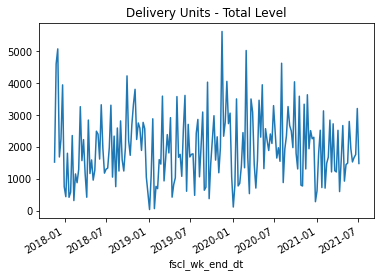

In [ ]:
hierarchy_df["total"].plot(title="Delivery Units - Total Level");

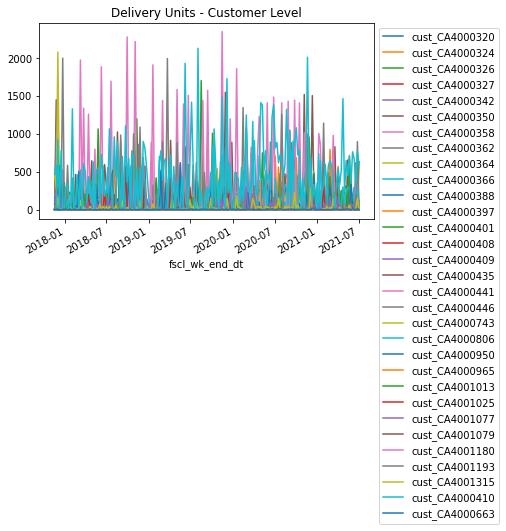

In [ ]:
ax = hierarchy_df[hierarchy['total_cust']].plot(title="Delivery Units - Customer Level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

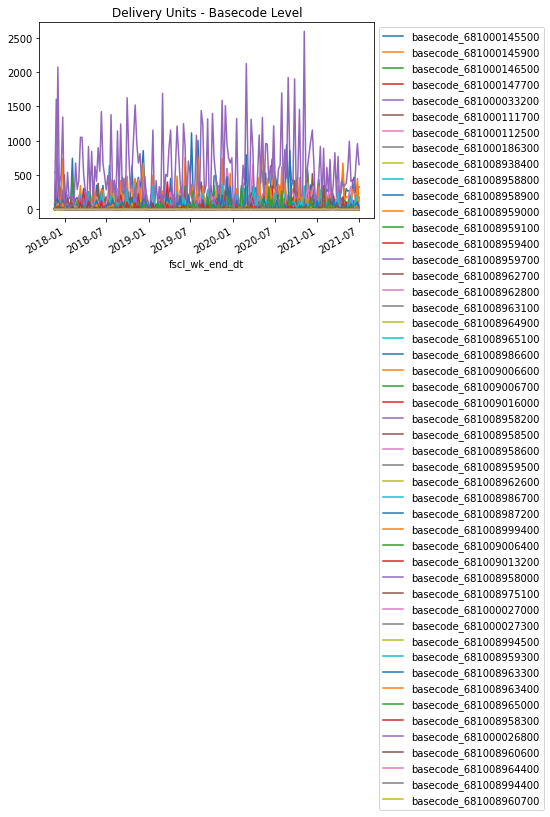

In [ ]:
ax = hierarchy_df[hierarchy['total_basecode']].plot(title="Delivery Units - Basecode Level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

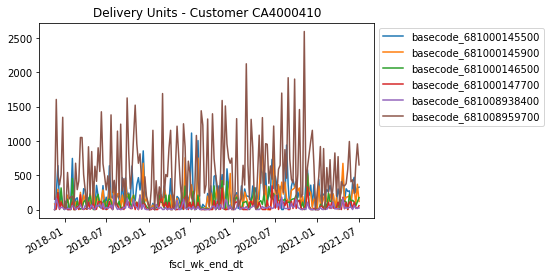

In [ ]:
ax = hierarchy_df[hierarchy['cust_CA4000410']].plot(title="Delivery Units - Customer CA4000410")
ax.legend(bbox_to_anchor=(1.0, 1.0));

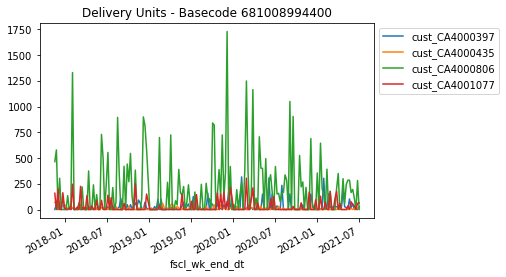

In [ ]:
ax = hierarchy_df[hierarchy['basecode_681008994400']].plot(title="Delivery Units - Basecode 681008994400")
ax.legend(bbox_to_anchor=(1.0, 1.0));

In [ ]:
original_df_bottom_level = df_bottom_level.copy()

In [ ]:
import pandas as pd
from htsprophet.hts import hts, orderHier, makeWeekly
from htsprophet.htsPlot import plotNode, plotChild, plotNodeComponents
import numpy as np

#%% Random data (Change this to whatever data you want)
date = pd.date_range("2015-04-02", "2017-07-17")
date = np.repeat(date, 10)
medium = ["Air", "Land", "Sea"]
businessMarket = ["Birmingham","Auburn","Evanston"]
platform = ["Stone Tablet","Car Phone"]
mediumDat = np.random.choice(medium, len(date))
busDat = np.random.choice(businessMarket, len(date))
platDat = np.random.choice(platform, len(date))
sessions = np.random.randint(1000,10000,size=(len(date),1))
data = pd.DataFrame(date, columns = ["day"])
data["medium"] = mediumDat
data["platform"] = platDat
data["businessMarket"] = busDat
data["sessions"] = sessions

data1 = makeWeekly(data)
data.head()

,day,medium,platform,businessMarket,sessions
0,2015-04-02,Sea,Stone Tablet,Birmingham,5470
1,2015-04-02,Air,Car Phone,Evanston,2090
2,2015-04-02,Air,Stone Tablet,Birmingham,9196
3,2015-04-02,Land,Stone Tablet,Birmingham,7585
4,2015-04-02,Air,Stone Tablet,Auburn,6885


In [ ]:
data1.head()

,week,medium,platform,businessMarket,sessions
0,2015-04-05,Air,Car Phone,Auburn,23388
1,2015-04-05,Air,Car Phone,Birmingham,5496
2,2015-04-05,Air,Car Phone,Evanston,5352
3,2015-04-05,Air,Stone Tablet,Auburn,22730
4,2015-04-05,Air,Stone Tablet,Birmingham,14603


In [ ]:
##
# Put the data in the format to run HTS, and get the nodes input (a list of list that describes the hierarchical structure)
##
data2, nodes = orderHier(data, 1, 2, 3)
data2.Total = data2['Total'].astype(float)
data2.head()

,time,Total,Sea,Air,Land,Sea_Stone Tablet,Sea_Car Phone,Air_Stone Tablet,Air_Car Phone,Land_Stone Tablet,Land_Car Phone,Sea_Stone Tablet_Birmingham,Sea_Stone Tablet_Evanston,Sea_Stone Tablet_Auburn,Sea_Car Phone_Birmingham,Sea_Car Phone_Evanston,Sea_Car Phone_Auburn,Air_Stone Tablet_Birmingham,Air_Stone Tablet_Evanston,Air_Stone Tablet_Auburn,Air_Car Phone_Birmingham,Air_Car Phone_Evanston,Air_Car Phone_Auburn,Land_Stone Tablet_Birmingham,Land_Stone Tablet_Evanston,Land_Stone Tablet_Auburn,Land_Car Phone_Birmingham,Land_Car Phone_Evanston,Land_Car Phone_Auburn
0,2015-04-02,64973.000000000000000,21319.000000000000000,25545.000000000000000,18109.000000000000000,5470.000000000000000,15849.000000000000000,16081.000000000000000,9464.000000000000000,18109.000000000000000,1.000000000000000,5470.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,15849.000000000000000,9196.000000000000000,1.000000000000000,6885.000000000000000,1.000000000000000,2090.000000000000000,7374.000000000000000,15359.000000000000000,2750.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000
1,2015-04-03,55937.000000000000000,10152.000000000000000,26066.000000000000000,19719.000000000000000,2000.000000000000000,8152.000000000000000,9584.000000000000000,16482.000000000000000,2329.000000000000000,17390.000000000000000,2000.000000000000000,1.000000000000000,1.000000000000000,8152.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,9584.000000000000000,2274.000000000000000,3262.000000000000000,10946.000000000000000,1.000000000000000,2329.000000000000000,1.000000000000000,9428.000000000000000,7962.000000000000000,1.000000000000000
2,2015-04-04,47190.000000000000000,34219.000000000000000,10475.000000000000000,2496.000000000000000,25311.000000000000000,8908.000000000000000,5407.000000000000000,5068.000000000000000,1.000000000000000,2496.000000000000000,8884.000000000000000,1.000000000000000,16427.000000000000000,5436.000000000000000,1.000000000000000,3472.000000000000000,5407.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,5068.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,2496.000000000000000
3,2015-04-05,35529.000000000000000,11627.000000000000000,9483.000000000000000,14419.000000000000000,6086.000000000000000,5541.000000000000000,6261.000000000000000,3222.000000000000000,14419.000000000000000,1.000000000000000,1190.000000000000000,1.000000000000000,4896.000000000000000,1.000000000000000,1.000000000000000,5541.000000000000000,1.000000000000000,1.000000000000000,6261.000000000000000,3222.000000000000000,1.000000000000000,1.000000000000000,5358.000000000000000,1.000000000000000,9061.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000
4,2015-04-06,53990.000000000000000,11643.000000000000000,25088.000000000000000,17259.000000000000000,5201.000000000000000,6442.000000000000000,13924.000000000000000,11164.000000000000000,1584.000000000000000,15675.000000000000000,1.000000000000000,1.000000000000000,5201.000000000000000,2645.000000000000000,3797.000000000000000,1.000000000000000,1.000000000000000,6855.000000000000000,7069.000000000000000,1588.000000000000000,9576.000000000000000,1.000000000000000,1584.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,15675.000000000000000,1.000000000000000


In [ ]:
nodes

[[3], [2, 2, 2], [3, 3, 3, 3, 3, 3]]

In [ ]:
'''
 method – (String)  the type of hierarchical forecasting method that the user wants to use. 
            Options:
            "OLS" - optimal combination using ordinary least squares (Default), 
            "WLSS" - optimal combination using structurally weighted least squares, 
            "WLSV" - optimal combination using variance weighted least squares, 
            "FP" - forcasted proportions (top-down)
            "PHA" - proportions of historical averages (top-down)
            "AHP" - average historical proportions (top-down)
            "BU" - bottom-up (simple addition)
            "CVselect" - select which method is best for you based on 3-fold Cross validation (longer run time)
 '''
##
# load in prophet inputs (Running HTS runs prophet, so all inputs should be gathered beforehand)
# Made up holiday data
##
holidates = pd.date_range("12/25/2013","12/31/2017", freq = 'A')
holidays = pd.DataFrame(["Christmas"]*5, columns = ["holiday"])
holidays["ds"] = holidates
holidays["lower_window"] = [-4]*5
holidays["upper_window"] = [0]*5
##
# Run hts with the CVselect function (this decides which hierarchical aggregation method to use based on minimum mean Mean Absolute Scaled Error)
# h (which is 12 here) - how many steps ahead you would like to forecast.  If youre using daily data you don't have to specify freq.
#
# NOTE: CVselect takes a while, so if you want results in minutes instead of half-hours pick a different method
##
myDict = hts(data2, 52, nodes, holidays = holidays, method = "FP", transform = "BoxCox")
##
# This output is a dictionary of dataframes, so you can do any further analysis that you may want. It also allows you to plot the forecasts.
# Some functions I've made are: (1 means I'm plotting the total node)
##
plotNode(myDict, "Total", h = 52, xlabel = "Week", ylabel = "Number of Sessions")
plotChild(myDict, "Total", h = 52, xlabel = "Week", ylabel = "Number of Sessions")
plotNodeComponents(myDict, column = "Total", holidays = holidays)

TypeError: ignored